# Fake News Exploratory Data Analysis

Get subset of FakeNewCorpus data set.

In [33]:
import pandas as pd
import regex as re
from cleantext import clean
raw_data = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv', dtype={"content": "string"})
raw_data.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


# Cleaning and preprocessing

Perform basic cleaning: remove urls, dates, numbers, emails.

In [34]:
data = raw_data.copy(deep = True)

In [35]:
pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
def clean_string(s):
    s1 = pattern.sub("date",s)
    s2 = clean(s1, lower=True,
                no_line_breaks=True,
                no_emails=True,
                no_urls=True,
                no_numbers=True,
                lang="en",
                replace_with_number="num",
                replace_with_email="email",
                replace_with_url="url")
    return s2
def clean_dataframe(dataframe):
    dataframe['content'] = dataframe['content'].apply(clean_string)

IndentationError: unexpected indent (3249400132.py, line 4)

In [ ]:
clean_dataframe(data)
data['content'].head()

0    sometimes the power of christmas will make you...
1    awakening of num strands of dna - "reconnectin...
2    never hike alone: a friday the 13th fan film u...
3    when a rare shark was caught, scientists were ...
4    donald trump has the unnerving ability to abil...
Name: content, dtype: object

Tokenize the text
Remove stopwords and compute reduction of vocabulary rate after having removed them
Stem words and compute reduction rate of vocabulary

In [ ]:
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import *
def remove_english_stopwords(stopwords):
    def remove_stopwords(tokenlist):
        return [token for token in tokenlist if token not in stopwords]
    return remove_stopwords
def stem_tokens():
    stemmer = PorterStemmer()
    def stem(tokenlist):
        return[stemmer.stem(token) for token in tokenlist]
    return stem
def preprocess(dataframe):
    # tokenize content column
    dataframe['content'] = dataframe['content'].apply(nltk.word_tokenize)
    print("Tokenizing...")
    tokens = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary = set(tokens)
    # remove stopwords
    d = stopwords.words('english')
    print("Removing stopwords...")
    dataframe['content'] = dataframe['content'].apply(remove_english_stopwords(d))
    tokens_no_stopwords = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_no_stopwords = set(tokens)
    print("Reduction rate of removing stopwords: " + str(1 - len(vocabulary_no_stopwords) / len(vocabulary)))
    print("Stemming...")
    dataframe['content'] = dataframe['content'].apply(stem_tokens())
    tokens_stem = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_stem = set(tokens_stem)
    print("Reduction rate of stemming: " + str(1 - len(vocabulary_stem)/len(vocabulary_no_stopwords)))

In [ ]:
preprocess(data)
data['content']

Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.0
Stemming...
Reduction rate of stemming: 0.3218335051233857


0      [sometim, power, christma, make, wild, wonder,...
1      [awaken, num, strand, dna, -, ``, reconnect, '...
2      [never, hike, alon, :, friday, 13th, fan, film...
3      [rare, shark, caught, ,, scientist, left, blun...
4      [donald, trump, unnerv, abil, abil, creat, rea...
                             ...                        
245    [prison, rahm, ,, god, 's, work, mani, other, ...
246    [num, use, item, tini, home, headlin, :, bitco...
247    [former, cia, director, michael, hayden, said,...
248    [antonio, sabato, jr., say, hollywood, 's, lib...
249    [former, u.s., presid, bill, clinton, monday, ...
Name: content, Length: 250, dtype: object

Next, we define functions that can visualize our dataset

# Visualization of data set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def pair_keyword_type(keyword): 
    dataarray = []
    for i in range(0,data.__len__()): 
        instances = data.content[i].count(str(keyword))
        dataarray.append((instances,data.type[i]))
    return dataarray

In [ ]:
def scatterplot_keyword_type(keyword):
    pair_keyword_list = pair_keyword_type(keyword)
    tuple_array = pair_keyword_type(keyword)
    typearray = []
    countarray = []
    for i in range(0,pair_keyword_list.__len__()): 
        typearray.append(str(tuple_array[i][1]))
        countarray.append(tuple_array[i][0])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.scatter(typearray,countarray)
    plt.xticks(rotation = 'vertical')
    plt.show()

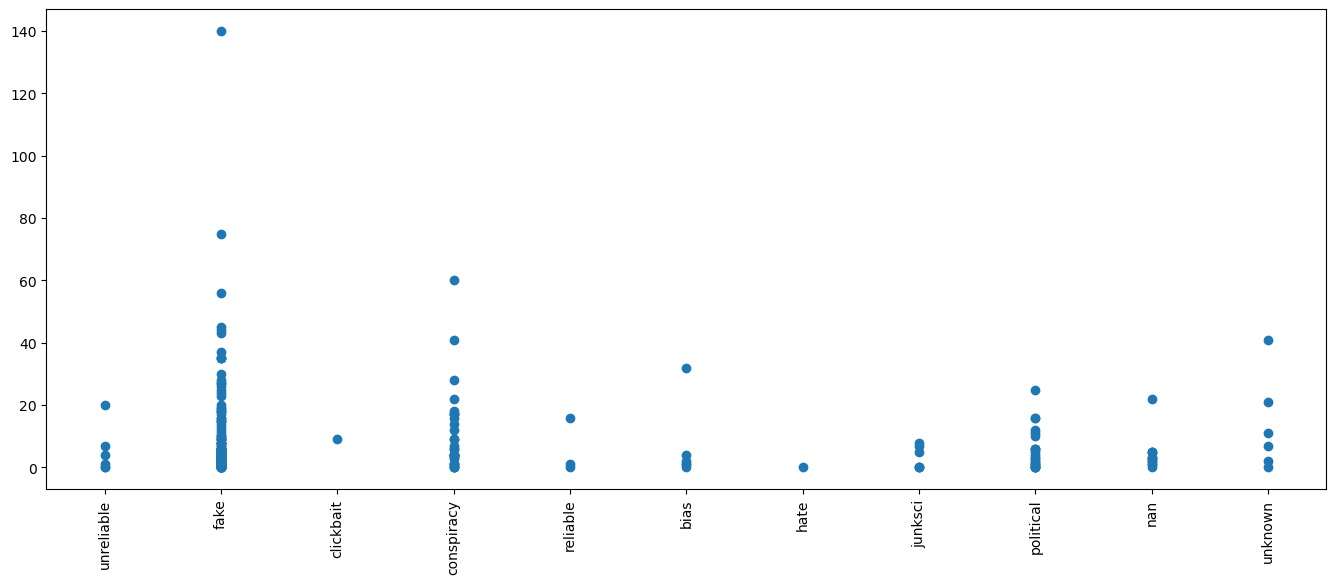

In [ ]:
scatterplot_keyword_type('num')

In [ ]:
def boxplot_keyword_type(keyword):
    tuple_array=pair_keyword_type(keyword) 
    boxdata=[]
    dict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in dict:
            dict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            dict[tuple_array[i][1]].append(tuple_array[i][0])
    for i in dict:
        boxdata.append(dict[i])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.boxplot(boxdata, labels = list(dict.keys()))
    plt.xticks(rotation = 'vertical')
    plt.show()

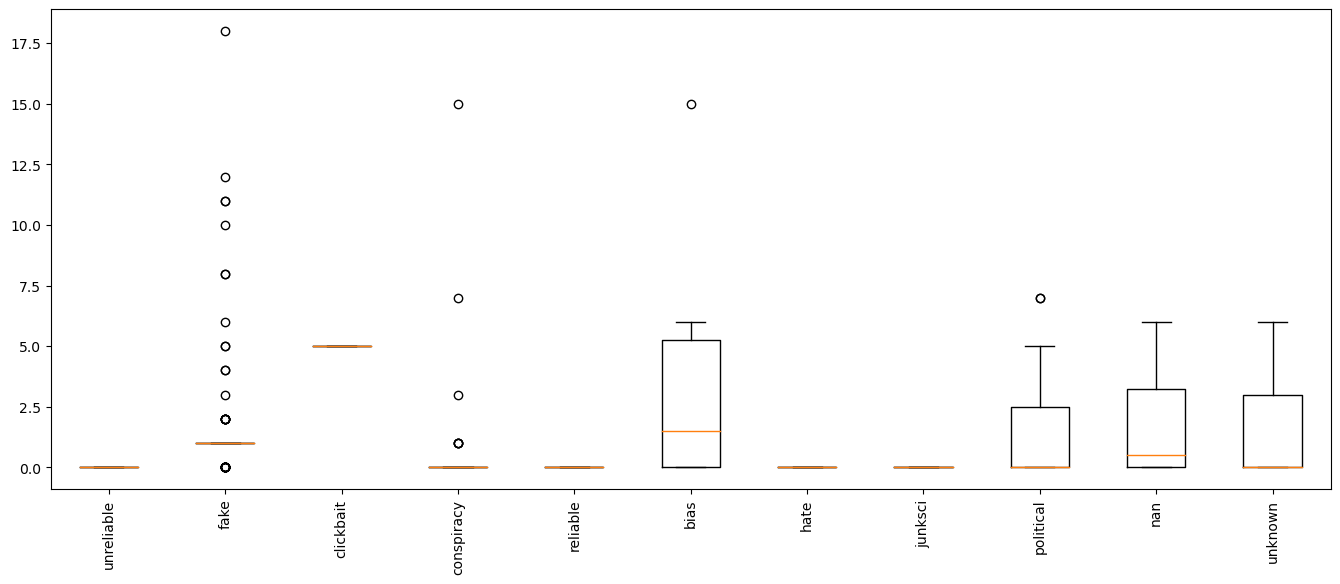

In [ ]:
boxplot_keyword_type('trump')

In [ ]:
def barplot_keyword_type(keyword): 
    tuple_array = pair_keyword_type(keyword)
    rawdict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in rawdict:
            rawdict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            rawdict[tuple_array[i][1]].append(tuple_array[i][0])

    meandict={}
    for i in rawdict: 
        meandict[i] = np.mean(rawdict[i])
    mediandict={}
    for i in rawdict: 
        mediandict[i] = np.median(rawdict[i])
    meanvals =[]
    medianvals=[]
    for i in mediandict:
        medianvals.append(mediandict[i])
    for i in meandict:
        meanvals.append(meandict[i])
    types = list(mediandict.keys())
    types = [str(i) for i in types]
    print(medianvals)
    print(meanvals)
    print(types)
    df = pd.DataFrame({
    'types': types,
    'meanvals': meanvals,
    'medianvals': medianvals
    })
    df.plot(x="types", y=["meanvals", "medianvals"], kind="bar", figsize=(10,5))
    

[2.5, 3.0, 9.0, 6.0, 1.0, 1.5, 0.0, 2.5, 3.0, 3.0, 9.0]
[5.333333333333333, 8.658064516129032, 9.0, 10.709677419354838, 5.666666666666667, 6.666666666666667, 0.0, 3.3333333333333335, 5.6521739130434785, 4.333333333333333, 13.666666666666666]
['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable', 'bias', 'hate', 'junksci', 'political', 'nan', 'unknown']


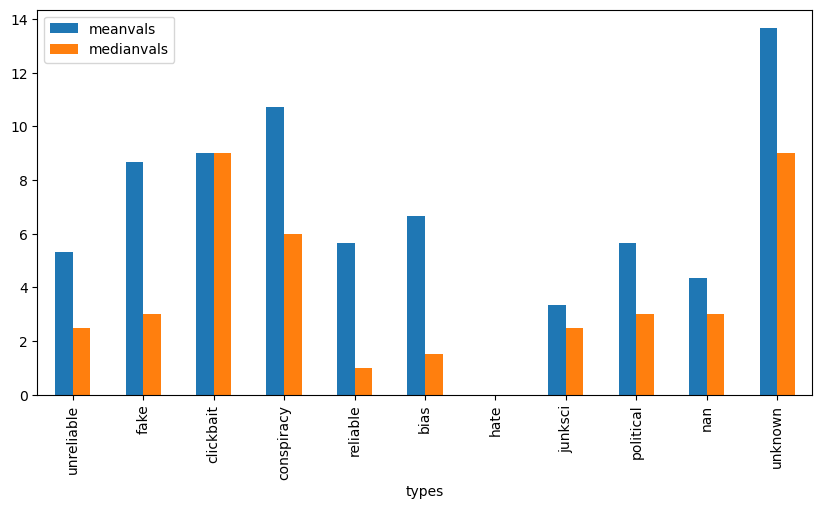

In [ ]:
barplot_keyword_type('num') 

# Converting full data set to hdf5

In [ ]:
import numpy as np
testdf = pd.DataFrame(np.arange(10).reshape(5,2), columns=['x', 'y'])
print(testdf)

   x  y
0  0  1
1  2  3
2  4  5
3  6  7
4  8  9


In [ ]:
with open("data/test.csv", "r") as file:
    for row in file:
        df = pd.DataFrame([row.split(",")], columns=["name", "age", "height"])
        print(df)

   name   age     height
0  name   age   height\n
    name  age height
0  mikke   21    188


In [ ]:
""" from IPython.display import display
from ipywidgets import IntProgress
import csv
rows = 216215374
column_names = []
with open("data/news_cleaned_2018_02_13-1.csv", "r") as file:
    for row in file:
        column_names = row.split(",")
        break
with open("data/news_cleaned_2018_02_13-1.csv", "r") as file:
    progress_bar = IntProgress(min=0, max=rows)
    display(progress_bar)
    reader = csv.reader(file)
    next(reader, None)
    for row in reader:
        store = pd.HDFStore("data/news_cleaned_2018_02_13-1.h5")
        df = pd.DataFrame([row], columns=column_names)
        store.append('data', df)
        store.close()
        progress_bar.value += 1 """

' from IPython.display import display\nfrom ipywidgets import IntProgress\nimport csv\nrows = 216215374\ncolumn_names = []\nwith open("data/news_cleaned_2018_02_13-1.csv", "r") as file:\n    for row in file:\n        column_names = row.split(",")\n        break\nwith open("data/news_cleaned_2018_02_13-1.csv", "r") as file:\n    progress_bar = IntProgress(min=0, max=rows)\n    display(progress_bar)\n    reader = csv.reader(file)\n    next(reader, None)\n    for row in reader:\n        store = pd.HDFStore("data/news_cleaned_2018_02_13-1.h5")\n        df = pd.DataFrame([row], columns=column_names)\n        store.append(\'data\', df)\n        store.close()\n        progress_bar.value += 1 '

In [ ]:
""" for i in range (3):
    df = pd.DataFrame(np.arange(10).reshape(5,2)*10**i, columns=['x','y'])
    store.append('data', df)

store.close()
store = pd.HDFStore(filename)
data = store['data']
print(data)
store.close() """

" for i in range (3):\n    df = pd.DataFrame(np.arange(10).reshape(5,2)*10**i, columns=['x','y'])\n    store.append('data', df)\n\nstore.close()\nstore = pd.HDFStore(filename)\ndata = store['data']\nprint(data)\nstore.close() "

In [ ]:
import csv
import pandas as pd
import h5py

In [ ]:
#full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", dtype={'content': "string"})

In [ ]:
for chunck in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=10000):
    print("cleaning...")
    clean_dataframe(chunck)
    print("preprocessing...")
    preprocess(chunck)
    break

cleaning...
preprocessing...
Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.0
Stemming...
Reduction rate of stemming: 0.24907369287772751


In [ ]:
#full_data.to_hdf("data.hf", key="full_data", mode="w")

NameError: name 'full_data' is not defined

In [ ]:
""" hf = h5py.File("data/news_cleaned_2018_02_13.h5", 'w')
hf.create_dataset('dataset', data=full_data)
hf.close() """
#filename = "data/news_cleaned_2018_02_13.h5"
""" for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1):
    print("opening file...")
    chunk.to_hdf(filename, 'data', mode='w', format='table')
    print(chunk.columns)
    break
for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1000):
    print(chunk.columns)
    clean(chunk)
    preprocess(chunk)
    chunk.to_hdf(filename, 'data', data_columns=chunk.columns, append=True) """
""" for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1000):
    store.append('data', chunk, data_columns=chunk.columns, min_itemsize={'content': 48577, 'title': 208})
store.close() """

' for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1000):\n    store.append(\'data\', chunk, data_columns=chunk.columns, min_itemsize={\'content\': 48577, \'title\': 208})\nstore.close() '

In [ ]:
y = df['type']

KeyError: 'type'

In [ ]:
len(df)

NameError: name 'df' is not defined

In [ ]:
# full_data.to_hdf("data/news_cleaned_2018_02_13.h5", key='df', mode='w')

: 

: 